# Liquid Crystal Discovery

**本Notebookの構成:**
1. **可視化 & 前処理**: データの理解とクリーニング。
2. **特徴量**: Sparse Matrixを用いた高次元特徴量 (ECFP4 + Bi-gram TF-IDF)。
3. **CV評価**: `StratifiedGroupKFold` を使用。
4. **全データ学習 (Refit)**: 確認した設定で**全データを学習**させ、提出用モデルを作成。

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy import sparse

# 化学系ライブラリ
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFingerprintGenerator

# 機械学習系
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, mean_squared_error
import lightgbm as lgb

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')

SEED = 42

/usr/local/lib/python3.12/dist-packages/sqlalchemy/orm/query.py:195: SyntaxWarning: "is not" with 'tuple' literal. Did you mean "!="?
  if entities is not ():


## 1. データ読み込み & 可視化

Train shape: (1074, 11)
Test shape: (1073, 6)


,row_id,compound_name,smiles_guess,lc_type,phase_transition_behavior,description,smiles_source,group_id,is_liquid_crystal,is_thermotropic_lc,clearing_point_celsius
0,0,"4,4''-Bis(heptanoyloxy)-p-terphenyl",CCCCCCC(=O)Oc1ccc(-c2ccc(-c3ccc(OC(=O)CCCCC)cc...,Thermotropic,Cr 66 X 96 SmF 226 SmI 232 SmC 250 SmA 251 I,A linear aromatic oligomer consisting of a p-t...,New_Gemini,paper_0526,True,1,251.0
1,1,Sodium N-alpha-myristoyllysinate,CCCCCCCCCCCCCC(=O)N[C@H](CCCCN)C(=O)[O-].[Na+],No-LC,NaN,A long-chain amino acid derivative synthesized...,New_Gemini,paper_0231,False,0,NaN
2,2,Ibuprofen,CC(C)CC1=CC=C(C=C1)C(C)C(=O)O,No-LC,NaN,A propionic acid derivative featuring a phenyl...,PubChem,paper_0186,False,0,NaN


Top 8 Molecules in Train:


[16:27:36] Can't kekulize mol.  Unkekulized atoms: 18 19 20 25 26 27 28 29 34 35


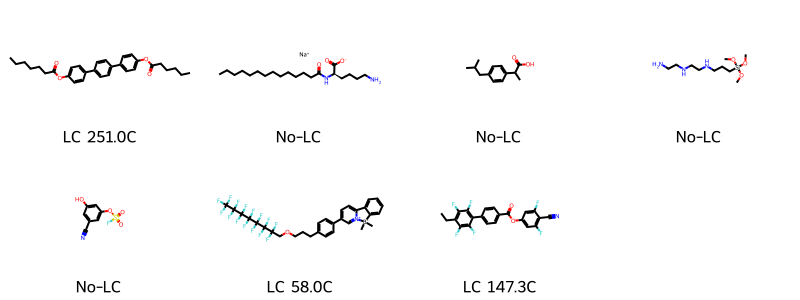

In [2]:
INPUT_DIR = '/kaggle/input/data-science-osaka-winter-2025/'
train = pd.read_csv(os.path.join(INPUT_DIR, 'train.csv'))
test = pd.read_csv(os.path.join(INPUT_DIR, 'test.csv'))
sample_sub = pd.read_csv(os.path.join(INPUT_DIR, 'sample_submission.csv'))

print(f'Train shape: {train.shape}')
print(f'Test shape: {test.shape}')

# テーブル表示
display(train.head(3))

# 分子構造の可視化
def visualize_molecules(df, smiles_col='smiles_guess', num=8):
    mols = []
    legends = []
    for i, row in df.head(num).iterrows():
        smiles = row[smiles_col]
        mol = Chem.MolFromSmiles(smiles)
        if mol:
            mols.append(mol)
            label = "LC" if row.get('is_thermotropic_lc', 0) == 1 else "No-LC"
            temp = f"{row['clearing_point_celsius']}C" if label == "LC" else ""
            legends.append(f"{label} {temp}")
    return Draw.MolsToGridImage(mols, molsPerRow=4, subImgSize=(200, 150), legends=legends)

print("Top 8 Molecules in Train:")
visualize_molecules(train)

## 2. 特徴量エンジニアリング
2048bit ECFP4 + Bi-gram TF-IDFを採用します。

In [3]:
# 1. ECFP4 (Morgan Fingerprint) - Sparse Matrix
def get_ecfp4_sparse(df, col='smiles_guess', n_bits=2048):
    morgan_gen = rdFingerprintGenerator.GetMorganGenerator(radius=2, fpSize=n_bits)
    fps = []
    for s in df[col]:
        mol = Chem.MolFromSmiles(s)
        if mol:
            fp = morgan_gen.GetFingerprintAsNumPy(mol)
            fps.append(fp)
        else:
            fps.append(np.zeros(n_bits, dtype=np.int8))
    return sparse.csr_matrix(np.array(fps))

print("Generating ECFP4...")
train_ecfp4 = get_ecfp4_sparse(train)
test_ecfp4 = get_ecfp4_sparse(test)

# 2. TF-IDF (1-gram & 2-gram)
train['description'] = train['description'].fillna('')
test['description'] = test['description'].fillna('')

print("Generating TF-IDF (1-2 gram)...")
tfidf = TfidfVectorizer(
    min_df=2, 
    max_features=50000, 
    ngram_range=(1, 2), # ここが重要！フレーズを捉える
    stop_words='english'
)

train_tfidf = tfidf.fit_transform(train['description'])
test_tfidf = tfidf.transform(test['description'])

# 3. 結合
X = sparse.hstack([train_ecfp4, train_tfidf], format='csr')
X_test = sparse.hstack([test_ecfp4, test_tfidf], format='csr')

# ターゲットとグループIDをNumpy配列化 (Sparse Matrixとの相性問題回避のため必須)
y_cls = train['is_thermotropic_lc'].values
y_reg = train['clearing_point_celsius'].values
groups = train['group_id'].values

print(f"Feature Matrix: {X.shape}")

Generating ECFP4...


[16:27:36] Can't kekulize mol.  Unkekulized atoms: 18 19 20 25 26 27 28 29 34 35
[16:27:36] Can't kekulize mol.  Unkekulized atoms: 3 4 5 6 7 11 12 13 14 15 16 17 18 22 26 30 34 38 42 46 50
[16:27:36] Can't kekulize mol.  Unkekulized atoms: 35 36 37 38 39 77 78 79 80 118 119 120
[16:27:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 144 145
[16:27:36] Can't kekulize mol.  Unkekulized atoms: 17 18 19 20 29
[16:27:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 16 145 146 147
[16:27:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 117 118
[16:27:36] Can't kekulize mol.  Unkekulized atoms: 13 14 15 96 97
[16:27:36] Can't kekulize mol.  Unkekulized atoms: 22 23 24 25 26 46 47 48 49 69 70 71
[16:27:36] Can't kekulize mol.  Unkekulized atoms: 18 19 20 25 26 27 28 29 34 35
[16:27:36] Can't kekulize mol.  Unkekulized atoms: 31 32 33 34 35 82 83 84 85 132 133 134
[16:27:36] Can't kekulize mol.  Unkekulized atoms: 27 28 29 30 31 62 63 64 65 96 97 98
[16:27:36] Can't kekulize mol.  

Generating TF-IDF (1-2 gram)...
Feature Matrix: (1074, 6328)


## 3. 評価指標 (Decoupled Rank Score)

本Notebookでは、コンペの指標に合わせて **Decoupled Rank Score** を計算します。

- パートA（分類）: 全データで Normalized Gini（= 2 * AUC - 1）
- パートB（回帰）: 正解が液晶（label=1）のサンプルのみで Spearman の順位相関
- 最終スコア: 0.5 * NormGini + 0.5 * Spearman


In [4]:
def decoupled_rank_score(y_true_cls, y_true_temp, pred_prob, pred_temp, return_parts=False):
    """Decoupled Rank Score (higher is better).

    Part A (Classification): Normalized Gini on all samples
        NormGini = 2 * AUC - 1

    Part B (Regression): Spearman rank correlation on LC-only samples (y_true_cls == 1)
        compares true temperature vs predicted temperature

    FinalScore = 0.5 * NormGini + 0.5 * Spearman
    """
    import numpy as np
    from sklearn.metrics import roc_auc_score
    from scipy.stats import spearmanr

    y = np.asarray(y_true_cls, dtype=float)
    t_true = np.asarray(y_true_temp, dtype=float)
    p = np.asarray(pred_prob, dtype=float)
    t_pred = np.asarray(pred_temp, dtype=float)

    # Part A: Normalized Gini (all samples)
    try:
        y_nonan = y[~np.isnan(y)]
        if np.unique(y_nonan).size < 2:
            norm_gini = 0.0
        else:
            auc = roc_auc_score(y, p)
            norm_gini = 2.0 * float(auc) - 1.0
    except Exception:
        norm_gini = 0.0

    # Part B: Spearman rho (LC-only samples)
    lc_mask = (y == 1)
    if int(np.sum(lc_mask)) < 2:
        rho = 0.0
    else:
        try:
            rho = spearmanr(t_true[lc_mask], t_pred[lc_mask], nan_policy="omit").correlation
        except TypeError:
            rho = spearmanr(t_true[lc_mask], t_pred[lc_mask]).correlation

        if rho is None or (isinstance(rho, float) and np.isnan(rho)):
            rho = 0.0
        rho = float(rho)

    final = 0.5 * norm_gini + 0.5 * rho
    if return_parts:
        return float(final), float(norm_gini), float(rho)
    return float(final)


## 4. 交差検証 (CV) - 評価用
ここでは予測値を作らず、あくまで「モデルの性能評価」と「特徴量の有用性確認」を行います。
本番予測は後ほど全データで行います。

Starting CV for Evaluation...
Fold 1 DecoupledRank: 0.2084 (NormGini=0.4943, Spearman=-0.0775)
Fold 2 DecoupledRank: 0.5421 (NormGini=0.9666, Spearman=0.1176)
Fold 3 DecoupledRank: 0.5274 (NormGini=0.8952, Spearman=0.1595)
Fold 4 DecoupledRank: 0.5532 (NormGini=0.7536, Spearman=0.3528)
Fold 5 DecoupledRank: 0.3974 (NormGini=0.7034, Spearman=0.0915)

>>> Overall CV DecoupledRank: 0.4664 (NormGini=0.7718, Spearman=0.1611) <<<


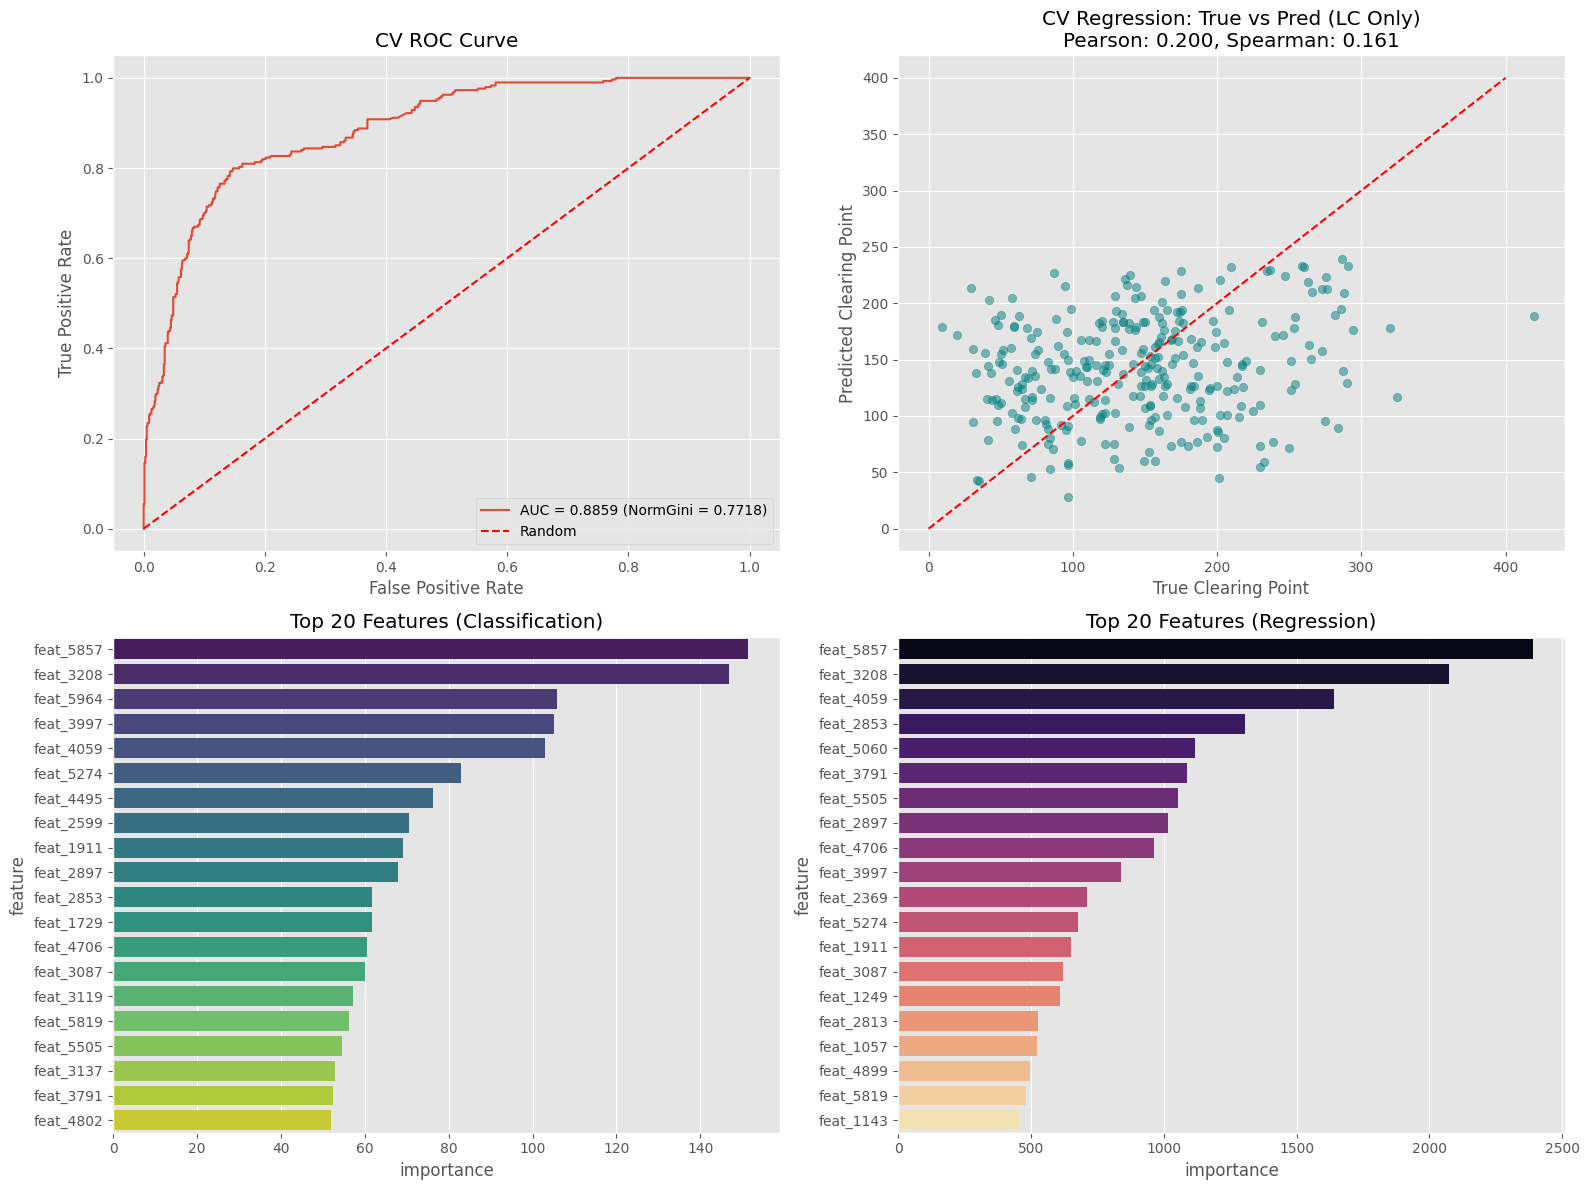

In [5]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import pearsonr, spearmanr

# --- Setup ---
sgkf = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=SEED)

oof_prob = np.zeros(len(train))
oof_temp = np.zeros(len(train))

# Initialize arrays to accumulate feature importance
# (Assuming X.shape[1] is the number of features)
feature_importance_clf = np.zeros(X.shape[1])
feature_importance_reg = np.zeros(X.shape[1])

params_clf = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'learning_rate': 0.03,
    'n_estimators': 2000,
    'num_leaves': 63,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1.0,
    'verbosity': -1,
    'random_state': SEED,
    'n_jobs': -1
}

params_reg = {
    'objective': 'regression',
    'metric': 'mae',
    'learning_rate': 0.02,
    'n_estimators': 4000,
    'num_leaves': 63,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_lambda': 1.0,
    'verbosity': -1,
    'random_state': SEED,
    'n_jobs': -1
}

print("Starting CV for Evaluation...")

for fold, (tr_idx, val_idx) in enumerate(sgkf.split(X, y_cls, groups)):
    # Slice Sparse Matrix
    X_tr, X_val = X[tr_idx], X[val_idx]
    y_cls_tr, y_cls_val = y_cls[tr_idx], y_cls[val_idx]
    y_reg_tr, y_reg_val = y_reg[tr_idx], y_reg[val_idx]
    
    # 1. Classification
    clf = lgb.LGBMClassifier(**params_clf)
    clf.fit(X_tr, y_cls_tr, eval_set=[(X_val, y_cls_val)], callbacks=[lgb.early_stopping(100, verbose=False)])
    oof_prob[val_idx] = clf.predict_proba(X_val)[:, 1]
    
    # Accumulate importance (Classification)
    feature_importance_clf += clf.feature_importances_ / sgkf.get_n_splits()
    
    # 2. Regression (LC Only)
    mask_tr = (y_cls_tr == 1)
    if mask_tr.sum() > 10:
        reg = lgb.LGBMRegressor(**params_reg)
        reg.fit(X_tr[mask_tr], y_reg_tr[mask_tr], 
                eval_set=[(X_tr[mask_tr], y_reg_tr[mask_tr])], 
                callbacks=[lgb.early_stopping(100, verbose=False)])
        oof_temp[val_idx] = reg.predict(X_val)
        
        # Accumulate importance (Regression)
        feature_importance_reg += reg.feature_importances_ / sgkf.get_n_splits()
    
    score, norm_gini, rho = decoupled_rank_score(y_cls_val, y_reg_val, oof_prob[val_idx], oof_temp[val_idx], return_parts=True)
    print(f"Fold {fold+1} DecoupledRank: {score:.4f} (NormGini={norm_gini:.4f}, Spearman={rho:.4f})")

overall, overall_gini, overall_rho = decoupled_rank_score(y_cls, y_reg, oof_prob, oof_temp, return_parts=True)
print(f"\n>>> Overall CV DecoupledRank: {overall:.4f} (NormGini={overall_gini:.4f}, Spearman={overall_rho:.4f}) <<<")

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. ROC Curve
fpr, tpr, thresholds = roc_curve(y_cls, oof_prob)
auc_score = roc_auc_score(y_cls, oof_prob)
norm_gini_all = 2 * auc_score - 1

axes[0, 0].plot(fpr, tpr, label=f'AUC = {auc_score:.4f} (NormGini = {norm_gini_all:.4f})')
axes[0, 0].plot([0, 1], [0, 1], 'r--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('CV ROC Curve')
axes[0, 0].legend()
axes[0, 0].grid(True)

# 2. Regression Scatter Plot (LC Only) with Metrics
lc_mask = (y_cls == 1)
y_true_lc = y_reg[lc_mask]
y_pred_lc = oof_temp[lc_mask]

# Pearson & Spearman
p_corr, _ = pearsonr(y_true_lc, y_pred_lc)
s_corr, _ = spearmanr(y_true_lc, y_pred_lc)

axes[0, 1].scatter(y_true_lc, y_pred_lc, alpha=0.5, c='teal')
axes[0, 1].plot([0, 400], [0, 400], 'r--')
axes[0, 1].set_title(f'CV Regression: True vs Pred (LC Only)\nPearson: {p_corr:.3f}, Spearman: {s_corr:.3f}')
axes[0, 1].set_xlabel('True Clearing Point')
axes[0, 1].set_ylabel('Predicted Clearing Point')
axes[0, 1].grid(True)

# 3. Feature Importance (Classification)
try:
    # Try to get feature names from vectorizer if available
    feat_names = vectorizer.get_feature_names_out()
except NameError:
    # Fallback if vectorizer is not in scope
    feat_names = [f"feat_{i}" for i in range(X.shape[1])]

df_imp_clf = pd.DataFrame({'feature': feat_names, 'importance': feature_importance_clf})
df_imp_clf = df_imp_clf.sort_values('importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=df_imp_clf, ax=axes[1, 0], palette='viridis')
axes[1, 0].set_title('Top 20 Features (Classification)')

# 4. Feature Importance (Regression)
df_imp_reg = pd.DataFrame({'feature': feat_names, 'importance': feature_importance_reg})
df_imp_reg = df_imp_reg.sort_values('importance', ascending=False).head(20)

sns.barplot(x='importance', y='feature', data=df_imp_reg, ax=axes[1, 1], palette='magma')
axes[1, 1].set_title('Top 20 Features (Regression)')

plt.tight_layout()
plt.show()

## 5. 全データでの再学習 (Full Fit) & 提出作成
ここが勝負所です。CVで検証したパラメータを使い、**全学習データ**でモデルを作り直します。
データの取りこぼしを無くし、テストデータに対する汎化性能を最大化します。

In [6]:
print("\nStarting Full Training for Submission...")

# 1. 分類モデル (全データ)
clf_full = lgb.LGBMClassifier(**params_clf)
clf_full.fit(X, y_cls)
pred_prob_test = clf_full.predict_proba(X_test)[:, 1]

# 2. 回帰モデル (全データ中のLCデータのみ)
mask_lc_all = (y_cls == 1)
reg_full = lgb.LGBMRegressor(**params_reg)
reg_full.fit(X[mask_lc_all], y_reg[mask_lc_all])
pred_temp_test = reg_full.predict(X_test)

print("Full Training Completed.")

# 提出ファイル作成
sub = pd.DataFrame({'row_id': test['row_id']})
sub['prediction'] = [f"[{p:.4f}, {t:.2f}]" for p, t in zip(pred_prob_test, pred_temp_test)]
sub.to_csv('submission.csv', index=False)

print("Saved: submission.csv")
sub.head()


Starting Full Training for Submission...
Full Training Completed.
Saved: submission.csv


,row_id,prediction
0,1074,"[0.2789, 171.88]"
1,1075,"[0.0000, 137.11]"
2,1076,"[0.0013, 134.91]"
3,1077,"[0.8085, 191.95]"
4,1078,"[0.1020, 120.90]"
